# Notebook to show the digitized verical subsidence lines of Wink

This website is used to convert a picture of a graph to actual data
https://apps.automeris.io/wpd/

![](dataset/Wink2016.png)
Figure taken from the paper:
Kim, Jin-Woo, Zhong Lu, and Kimberly Degrandpre (Apr. 2016). “Ongoing Deformation of Sinkholesin Wink, Texas, Observed by Time-Series Sentinel-1A SAR Interferometry (Preliminary Results)”.In: Remote Sensing 8.4, p. 313. DOI:10.3390/rs8040313.

In [1]:
#imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os, sys, time
import re
import datetime

#folder containing all the datasets
folder = 'dataset/Wink2016'

#create list of locations of the datasets
datasets_locations = []
for item in os.listdir(folder):
    if item.endswith('.csv'):
        datasets_locations.append(item)

#sort the datasets
datasets_locations = sorted(datasets_locations)
        
#filter out the datas from the dataset locations
dates_str = list(map(lambda x:re.findall(r"^\d+",x)[0],datasets_locations))

#converts string dates to datetime objects
dates = list(map(lambda x: datetime.datetime.strptime(x,'%Y%m%d'),dates_str))

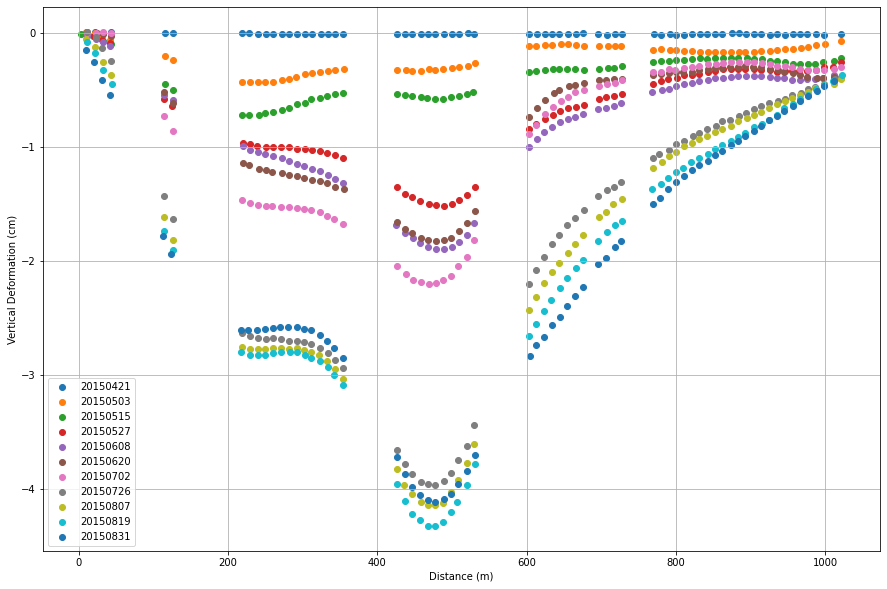

In [2]:
#load the data into a list with panda objects
data_list = []

for date,item in zip(dates_str,datasets_locations):
    temp = pd.read_csv(os.path.join(folder,item),header=None,names=['x',date])
    data_list.append(temp)
    
plt.figure(figsize=(15,10))

for date,item in zip(dates_str,data_list):
    plt.scatter(item['x'],item[date],label=date)
    
plt.grid(True)
plt.ylabel('Vertical Deformation (cm)')
plt.xlabel('Distance (m)')
plt.legend();

## Fit a kinemetic model through the measurement points

The above figure shows all the available data points for diffent epochs. Not sure if a model can be fit through these points. It looks like there are three stages and an accelerating subsidence pattern. 

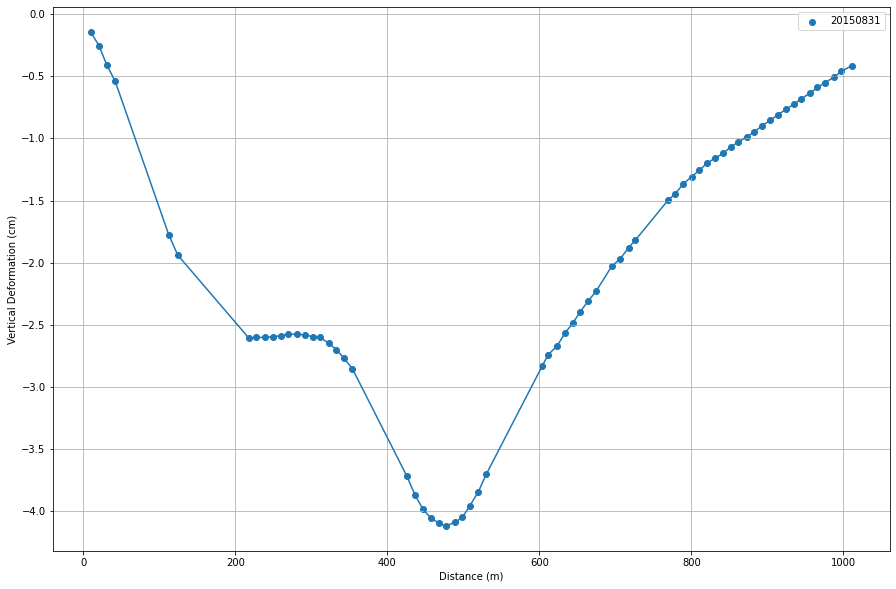

In [3]:
#selecting the test date
date_test = '20150831'
idx = dates_str.index(date_test)

x_range = data_list[idx]['x']
z_data = data_list[idx][date_test]

plt.figure(figsize=(15,10))
plt.plot(x_range,z_data)
plt.scatter(x_range,z_data,label=date_test)

plt.ylabel('Vertical Deformation (cm)')
plt.xlabel('Distance (m)')
plt.legend()
plt.grid(True);

## How to fit the Gaussian influence function to the graph above?

Two ways:
- Assume X0 and R so that only the S (maximum subsidence has to calculated)
- Non-linear LSQ -> maybe later

In [4]:
def zg(x,x0,y,y0,R):
    return -(1/(R*R))*np.exp(-np.pi * ((x-x0)**2 + (y-y0)**2)/R**2)

In [5]:
# assuming parameters x0 and R
x0 = 480
R = 480

#creating the LSQ
A = zg(x_range.values,x0,0,0,R) #len(x_range) by 1 matrix
y = z_data.values

A = A.reshape((1,len(y)))

#stochastic matrix
W = np.eye((len(y)))

#compute solutions
invW = np.linalg.inv(W)

Qxhat = np.linalg.inv(A @ invW @ A.T)
xhat = Qxhat @ A @ invW @ y

yhat1 = A.T @ xhat
ehat = y - yhat1

print('Done')

Done


### NOTE
The units are a little messed up. R and x0 are in meters but the result is in centimeters?

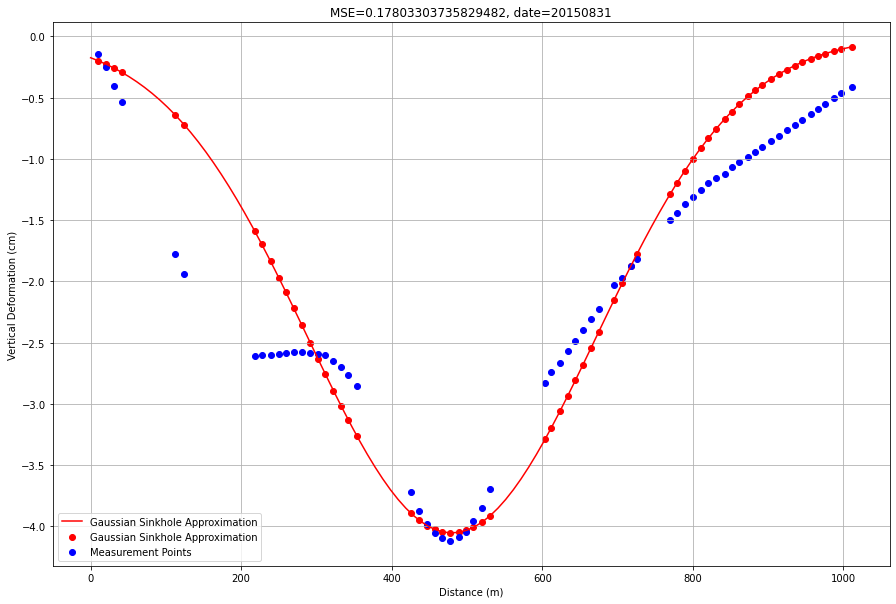

In [6]:
#plotting the results

x_range2 = np.linspace(0,max(x_range),100)
zg2 = xhat*zg(x_range2,x0,0,0,R)

plt.figure(figsize=(15,10))

plt.plot(x_range2,zg2,c='r',label='Gaussian Sinkhole Approximation')
plt.scatter(x_range.values,yhat1,c='r',label='Gaussian Sinkhole Approximation')
plt.scatter(x_range,z_data,c='b',label='Measurement Points')

MSE = (ehat @ ehat.T)/len(y)

plt.title(f'MSE={MSE}, date={date_test}')
plt.ylabel('Vertical Deformation (cm)')
plt.xlabel('Distance (m)')
plt.legend()
plt.grid(True);

In [13]:
100*(1-np.sum(abs(ehat))/np.sum(abs(z_data)))

83.46807276996836

## Computing the Subsidence rates using LSQ

In [7]:
def linear_model(dataset,date):
    # assuming parameters x0 and R
    x0 = 480
    R = 480
    
    #extract the data
    x_range = dataset
    z_data = date
    
    #creating the LSQ
    A = zg(x_range.values,x0,0,0,R) #len(x_range) by 1 matrix
    y = z_data.values

    A = A.reshape((1,len(y)))

    #stochastic matrix
    W = np.eye((len(y)))

    #compute solutions
    invW = np.linalg.inv(W)

    Qxhat = np.linalg.inv(A @ invW @ A.T)
    xhat = Qxhat @ A @ invW @ y

    yhat = A.T @ xhat
    ehat = y - yhat
    
    return xhat, yhat, ehat

def get_delta_day(epochs):
#     dates = list(map(lambda x: datetime.datetime.strptime(x,'d_%Y%m%d'),epochs))
    start_date = epochs[0]
    dates_days = np.array(list(map(lambda x: (x-start_date).days,epochs)))

    return dates_days, start_date

[  7835.40216846 -10296.04645826]


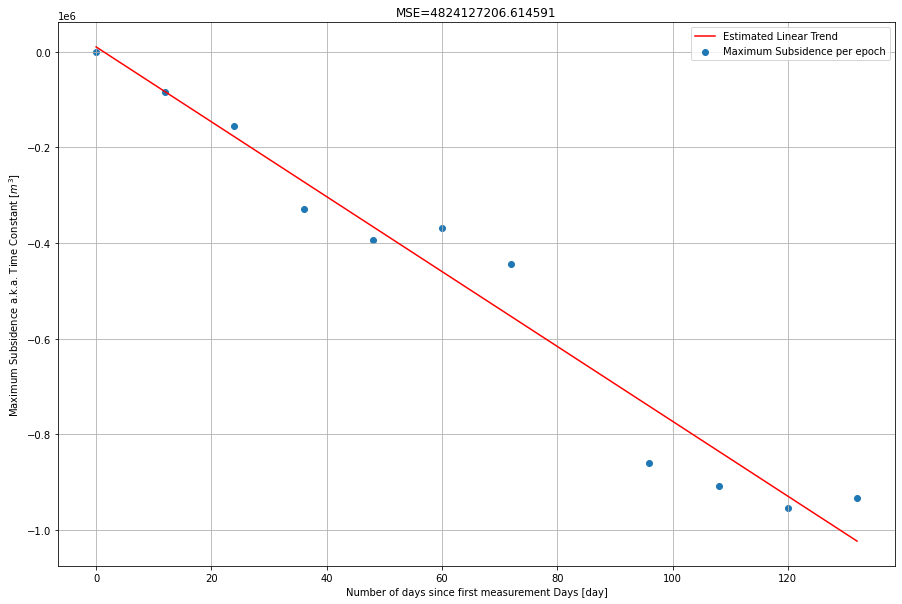

In [8]:
dates_days, start_date = get_delta_day(dates)

S = [] #maximum subsidence but also the parameter for the time vector

for date, item in zip(dates_str,data_list):
    xhat,yhat, ehat = linear_model(item['x'],item[date])
    S.append(xhat[0])

#create trend through points
y = S
A = np.array([dates_days,np.ones(len(y))])


A = A.reshape((2,len(y)))

#stochastic matrix
W = np.eye((len(y)))

#compute solutions
invW = np.linalg.inv(W)

Qxhat = np.linalg.inv(A @ invW @ A.T)
xhat = Qxhat @ A @ invW @ y

yhat = A.T @ xhat
ehat = y - yhat
    
#plot results
plt.figure(figsize=(15,10))
plt.scatter(dates_days,-1*np.array(S),label='Maximum Subsidence per epoch')
plt.plot(dates_days,-yhat,c='r',label='Estimated Linear Trend')

MSE = (ehat @ ehat.T)/len(y)

plt.title(f'MSE={MSE}')
plt.ylabel('Maximum Subsidence a.k.a. Time Constant [$m^3$]')
plt.xlabel('Number of days since first measurement Days [day]')
plt.legend()
plt.grid(True);

print(xhat)

## Compare Subsidence Profile Line with Mogi Model

In [9]:
def mogi(dV,v,x,y,z,x0,y0,z0):
    r = np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)
    return dV * ((1-v)/np.pi) * np.array([(x-x0)/r**3,(y-y0)/r**3,(z-z0)/r**3])

In [10]:
def mogi_nodV(v,x,y,z,x0,y0,z0):
    r = np.sqrt((x-x0)**2 + (y-y0)**2 + (z-z0)**2)
    return ((1-v)/np.pi) * np.array([(x-x0)/r**3,(y-y0)/r**3,(z-z0)/r**3])

def linear_model_mogi(dataset,date):
    #extract the data
    x_range = dataset
    z_data = date
    
    # assuming parameters x0 and R
    x0 = 480
    R = 480
    
    H = R*np.tan(np.deg2rad(35))
    z0 = -H
    zv = np.zeros((len(x_range)))
    v = 0.3

    
    #creating the LSQ
    a,b,A = mogi_nodV(v,x_range,0,zv,x0,0,z0) #len(x_range) by 1 matrix
    y = z_data.values

    A = A.reshape((1,len(y)))

    #stochastic matrix
    W = np.eye((len(y)))

    #compute solutions
    invW = np.linalg.inv(W)

    Qxhat = np.linalg.inv(A @ invW @ A.T)
    xhat = Qxhat @ A @ invW @ y

    yhat = A.T @ xhat
    ehat = y - yhat
    
    return xhat, yhat, ehat

Delta volume of the mogi source is: [-19362.56208074] at depth: 336.09961834066064


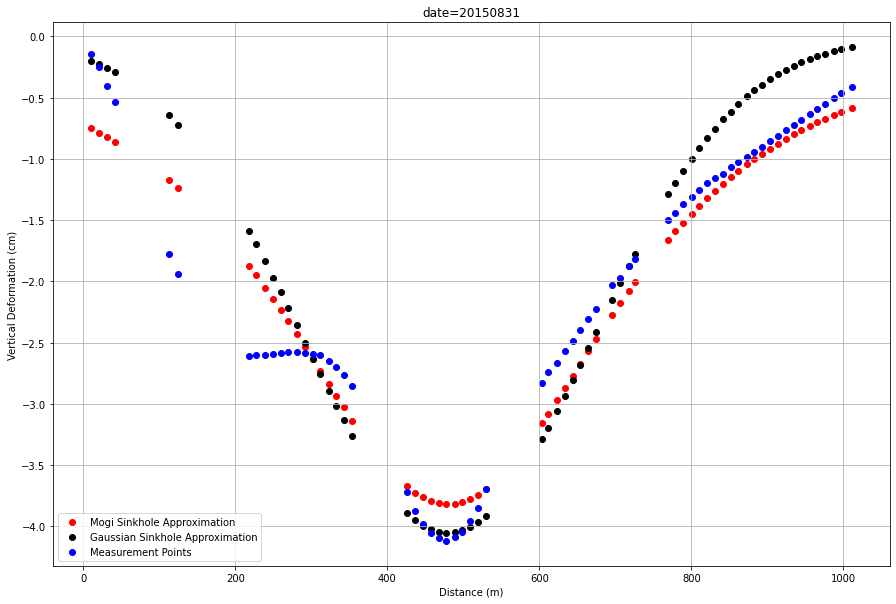

In [11]:
H = R*np.tan(np.deg2rad(35))
z0 = -H
zv = np.zeros((len(x_range)))
v = 0.3

dV, yhat, ehat = linear_model_mogi(x_range,z_data/100) #z data to meters instead of cm

# u, v1, w1 = mogi(-V,v,x_range,0,zv,x0,0,z0)

u, v1, w1 = mogi_nodV(v,x_range,0,zv,x0,0,z0)

print(f'Delta volume of the mogi source is: {dV} at depth: {H}')

plt.figure(figsize=(15,10))

# plt.plot(x_range2,zg2,c='r',label='Gaussian Sinkhole Approximation')
plt.scatter(x_range,dV*(w1*100),c='r',label='Mogi Sinkhole Approximation')
plt.scatter(x_range.values,yhat1,c='k',label='Gaussian Sinkhole Approximation')
plt.scatter(x_range,z_data,c='b',label='Measurement Points')

# MSE = (ehat @ ehat.T)/len(y)

plt.title(f'date={date_test}')
plt.ylabel('Vertical Deformation (cm)')
plt.xlabel('Distance (m)')
plt.legend()
plt.grid(True);

500x20x40

![](Dataset/Wink_sinkhole_geology.png)

# Conclusion

- Linear time approximation looks like it is sufficient
- The deformation time-series looks like it consists of two 'moments' with both the shape of a log time vector